In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datetime

from dsmanipulator import dsanalyzer as dsa
from dsmanipulator import dsloader as dsl
from dsmanipulator import dscreator as dsc
from dsmanipulator.utils import FileColumnNames


In [2]:
fcn = FileColumnNames("TimeStamp", "Relative Time", "srcIP", "dstIP", "srcPort", "dstPort")

filename = "../data/mega104-14-12-18-ioa.csv"

dialect = dsl.detect_dialect(filename)
df = dsl.load_data(
    filename,
    data_types={
        "TimeStamp": "datetime",
        "Relative Time": "float",
        "srcIP": "object",
        "dstIP": "object",
        "srcPort": "float",
        "dstPort": "float",
        "ipLen": "float",
        "len": "float",
        "fmt": "object",
        "uType": "object",
        "asduType": "float",
        "numix": "float",
        "cot": "float",
        "oa": "float",
        "addr": "float",
        "ioa": "object",
    },
    dialect=dialect,
    row_limit=None,
)

dsc.add_relative_days(df, fcn, inplace=True)
station_ids = dsc.create_station_ids(df, fcn)
dsc.add_station_id(df, fcn, station_ids, inplace=True)
pair_ids = dsc.create_pair_ids(df, fcn)
dsc.add_pair_id(df, fcn, pair_ids, inplace=True)
direction_ids = dsc.create_direction_ids(df, fcn)
dsc.add_direction_id(df, fcn, direction_ids, inplace=True)


,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,len,fmt,uType,...,numix,cot,oa,addr,ioa,*Relative Day##,*Source station id##,*Destination station id##,*Pair id##,*Direction id##
0,2022-04-28 17:15:49.910,0.000000,192.168.11.111,192.168.11.248,56693.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,1,0,1
1,2022-04-28 17:15:49.940,0.029377,192.168.11.248,192.168.11.111,2404.0,56693.0,61.0,19.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,1,0,0,0
2,2022-04-28 17:15:49.940,0.029617,192.168.11.111,192.168.11.248,56693.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,1,0,1
3,2022-04-28 17:15:49.940,0.031586,192.168.11.248,192.168.11.111,2404.0,56693.0,62.0,20.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,1,0,0,0
4,2022-04-28 17:15:49.970,0.062488,192.168.11.111,192.168.11.248,56693.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14592,2022-04-29 08:53:34.300,56264.388718,192.168.11.111,192.168.11.248,56693.0,2404.0,46.0,4.0,0x00000001,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,1,0,1
14593,2022-04-29 08:53:37.280,56267.374012,192.168.11.248,192.168.11.111,2404.0,56693.0,67.0,25.0,0x00000000,NaN,...,1.0,3.0,0.0,65535.0,2,1,1,0,0,0
14594,2022-04-29 08:53:41.280,56271.373875,192.168.11.248,192.168.11.111,2404.0,56693.0,67.0,25.0,0x00000000,NaN,...,1.0,3.0,0.0,65535.0,2,1,1,0,0,0
14595,2022-04-29 08:53:47.340,56277.434238,192.168.11.111,192.168.11.248,56693.0,2404.0,46.0,4.0,0x00000001,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,1,0,1


In [3]:
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import seaborn as sns
from dsmanipulator import dscreator as dsc
from dsmanipulator.utils import Direction, FileColumnNames, Station
from bidict import bidict


def plot_pair_flow(
    df: pd.DataFrame,
    fcn: FileColumnNames,
    axes: Axes,
    pair_id: int,
    station_ids: bidict[int, Station],
    direction_ids: bidict[int, Direction],
    resample_rate: pd.Timedelta,
) -> None:
    assert all(col in df.columns for col in [fcn.timestamp, fcn.pair_id, fcn.direction_id])

    # filter original dataframe and expand values
    # tmpdf = df
    tmpdf = df[df[fcn.pair_id] == pair_id]
    tmpdf = dsc.expand_values_to_columns(tmpdf, fcn.direction_id, drop_column=True)

    # names of expanded columns
    expanded_cols: list[str] = list(filter(lambda x: fcn.direction_id in x, tmpdf.columns))

    # filter only timestamp and expanded columns
    tmpdf = tmpdf[[fcn.timestamp] + expanded_cols]

    # rename expanded cols so that the legend shows relevant information
    renamed_cols: dict[str, str] = {}
    for col in expanded_cols:
        # TODO parse error
        direction_id = int(col.rsplit(":", 1)[1])
        src_station = station_ids[direction_ids[direction_id].src]
        dst_station = station_ids[direction_ids[direction_id].dst]
        renamed_cols[col] = f"{src_station} -> {dst_station}"

    tmpdf = tmpdf.rename(columns=renamed_cols)

    # convert index to datetimeindex for resampling
    tmpdf = dsc.convert_to_timeseries(tmpdf, fcn)
    tmpdf = tmpdf.resample(resample_rate).sum()

    # create column with sum
    tmpdf.insert(0, "Sum", 0)
    tmpdf["Sum"] = tmpdf.sum(axis=1)

    axes.set_xlabel(" ")
    # axes.set_ylabel("Packet count")
    # axes.set_title("Packet count in time")
    axes.grid(True)

    axes.xaxis.set_major_locator(AutoDateLocator())
    axes.xaxis.set_major_formatter(DateFormatter("%H:%M"))

    # plt.xlim([min(tmpdf.index), max(tmpdf.index)])
    # print(min(k))
    # print(max(k))
    # k = pd.DatetimeIndex(df[fcn.timestamp])
    # axes.set_xlim([min(k), max(k)])
    # axes.legend([], [], frameon=False)
    # print("OG")
    # print(tmpdf)
    # # tmpdf = tmpdf.loc[:'Sum']
    # print("SUMMED")
    # print(tmpdf)
    # c = tmpdf



    # drop non sum columns
    dropcols = [x for x in tmpdf.columns if x != 'Sum']
    tmpdf = tmpdf.drop(dropcols, axis=1)



    sns.lineplot(data=tmpdf, palette="tab10", linewidth=3, ax=axes)

    # print(tmpdf)
    # axes.xaxis.set_major_locator(AutoDateLocator())
    # axes.xaxis.set_major_formatter(DateFormatter("%H:%M"))

    # plt.xlim([min(x), max(x)])
    # plt.ylim([0, max(y)])

In [4]:
from datetime import datetime
# df[fcn.timestamp][0]

# https://www.epochconverter.com/


start = pd.Timestamp('2022-04-25 18:00:00')
end = pd.Timestamp('2022-04-25 19:00:00')

start_drop = pd.Timestamp('2022-04-25 18:15:00')
end_drop = pd.Timestamp('2022-04-25 18:17:00')
end_drop



Timestamp('2022-04-25 18:17:00')

[]

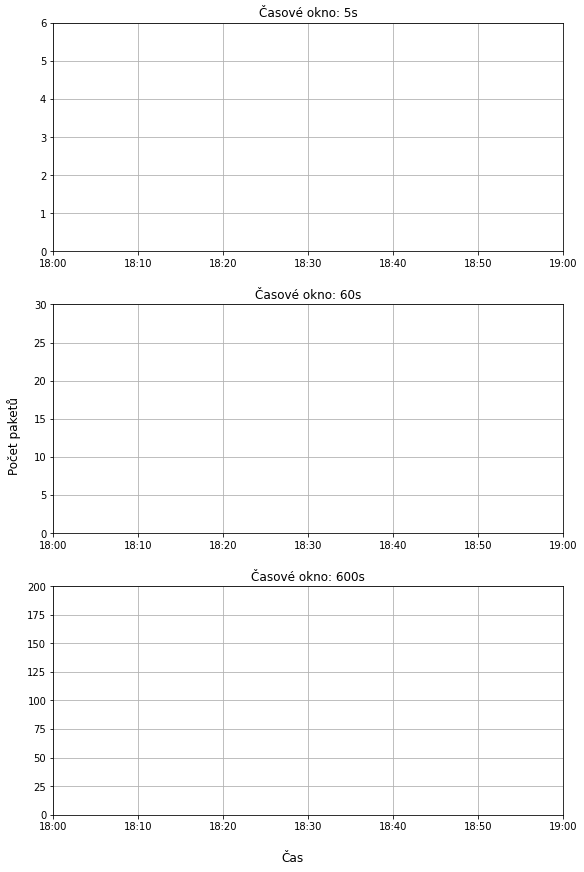

In [5]:
from datetime import timedelta


fig, axs = plt.subplots(3,1,figsize=(8, 12),constrained_layout = True)



axs[0].set_xlim([start, end])
axs[0].set_ylim([0,6])
axs[1].set_xlim([start, end])
axs[1].set_ylim([0,30])
axs[2].set_xlim([start, end])
axs[2].set_ylim([0,200])

dropped_df = df[(df[fcn.timestamp] > end_drop) | (df[fcn.timestamp] < start_drop)]

# fig.axes.set_xlim([, ])
plot_pair_flow(
    dropped_df, fcn, axs[0], 0, station_ids, direction_ids, timedelta(seconds=5)
)

plot_pair_flow(
    dropped_df, fcn, axs[1], 0, station_ids, direction_ids, timedelta(minutes=1)
)

plot_pair_flow(
    dropped_df, fcn, axs[2], 0, station_ids, direction_ids, timedelta(minutes=10)
)

axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)
axs[2].legend([], [], frameon=False)

axs[0].set_title("Časové okno: 5s")
axs[1].set_title("Časové okno: 60s")
axs[2].set_title("Časové okno: 600s")

fig.supxlabel("Čas")
fig.supylabel("Počet paketů")

plt.plot()

# plt.savefig('pgf/time_series_wrong_tw.pgf')


In [6]:
df["oa"].value_counts()


0.0    9657
Name: oa, dtype: int64

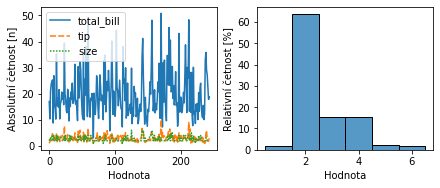

In [7]:
# penguins = sns.load_dataset("penguins")
# sns.histplot(data=penguins, x="flipper_length_mm")
# planets = sns.load_dataset("planets")
# sns.histplot(data=planets, x="distance", log_scale=True)
fig, ax = plt.subplots(1,2, figsize=(6, 2.5), constrained_layout = True)

# fig.tight_layout(w_pad=2)

tips = sns.load_dataset("tips")
# sns.histplot(data=tips, x="size", discrete=True, ax=ax[0])
sns.lineplot(data=tips,  ax=ax[0])
sns.histplot(data=tips, x="size", stat="percent", discrete=True, ax=ax[1])

ax[0].set_xlabel("Hodnota")
ax[0].set_ylabel("Absolutní četnost [n]")

ax[1].set_xlabel("Hodnota")
ax[1].set_ylabel("Relativní četnost [%]")


plt.savefig("pgf/histogram.pgf")


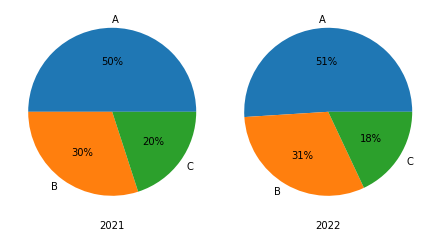

In [16]:
labels = ['A', 'B', 'C']


fig, axes = plt.subplots(1, 2, constrained_layout = True)

#create pie chart
# plt.pie(data, labels = labels, autopct='%.0f%%')
# plt.show()

axes[0].pie([50, 30, 20], labels = labels, autopct='%.0f%%')
axes[1].pie([51, 31, 18], labels = labels, autopct='%.0f%%')

axes[0].set_xlabel("2021")
axes[1].set_xlabel("2022")


plt.savefig("pgf/pies.pgf")

/home/ankimme/fit/ibt/env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ankimme/fit/ibt/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ankimme/fit/ibt/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or

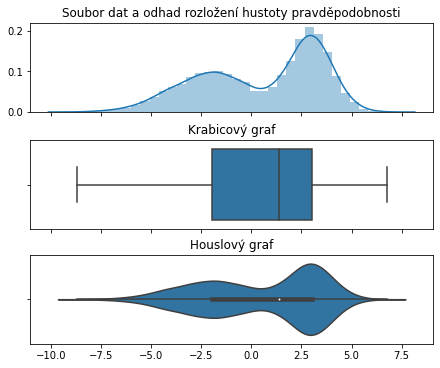

In [33]:
def plot_comparison(x, title):
    fig, ax = plt.subplots(3, 1,figsize=(6, 5),  sharex=True, constrained_layout = True)
    sns.distplot(x, ax=ax[0])
    ax[0].set_title('Soubor dat a odhad rozložení hustoty pravděpodobnosti')
    ax[0].set_ylabel("")
    sns.boxplot(x, ax=ax[1])
    ax[1].set_title('Krabicový graf')
    sns.violinplot(x, ax=ax[2])
    ax[2].set_title('Houslový graf')
    # fig.suptitle(title, fontsize=16)
    plt.savefig("pgf/box_violin.pgf")

    plt.show()

N = 10000
# sample_gaussian = np.random.normal(size=N)
# plot_comparison(sample_gaussian, 'Standard Normal Distribution')

sample_bimodal = np.concatenate([np.random.normal(loc=-2, scale=2, size=int(N/2)),
                                 np.random.normal(loc=3, scale=1, size=int(N/2))])
plot_comparison(sample_bimodal, 'Mixture of Gaussians - bimodal')

In [46]:
detected_cols = df.dtypes.to_dict()

detected_cols = {k:('float' if v == 'int' else v) for k,v in detected_cols.items()}
detected_cols = {k:(v if v in ['datetime', 'float', 'object'] else "object") for k,v in detected_cols.items()}
# {k:(v if True else 4) for k,v in detected_cols.items()}
detected_cols

{'TimeStamp': 'object',
 'Relative Time': dtype('float64'),
 'srcIP': dtype('O'),
 'dstIP': dtype('O'),
 'srcPort': dtype('float64'),
 'dstPort': dtype('float64'),
 'ipLen': dtype('float64'),
 'len': dtype('float64'),
 'fmt': dtype('O'),
 'uType': dtype('O'),
 'asduType': dtype('float64'),
 'numix': dtype('float64'),
 'cot': dtype('float64'),
 'oa': dtype('float64'),
 'addr': dtype('float64'),
 'ioa': dtype('O'),
 '*Relative Day##': 'float',
 '*Source station id##': 'float',
 '*Destination station id##': 'float',
 '*Pair id##': 'float',
 '*Direction id##': 'float'}

In [8]:
station_ids

bidict({0: Station(ip='192.168.11.111', port=56693.0), 1: Station(ip='192.168.11.248', port=2404.0)})

##### Unique asdu types in all datasets

In [9]:
a = np.array([122., 120., 121., 125., 123., 124.,  36.])
b=np.array([31., 36.])
c=np.array([122., 120., 121., 125., 123., 124.,  36.])
d=np.array([122., 120., 121., 125., 123., 124.,  36.])
np.unique(np.concatenate([a,b,c,d]))

array([ 31.,  36., 120., 121., 122., 123., 124., 125.])